In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.stats import vonmises
from scipy.interpolate import CubicSpline

In [2]:
IOC_45 = 77.88051081011038
VS_45 = 36.456845185107724
IOC_135 = 81.45684518510772
VS_135 = 122.88051081011038
IOC_20 = 83.62308215238046
VS_20 = 16.039209988994372
IOC_160 = 86.03920998899437
VS_160 = 153.62308215238045
VS_dict= {20:VS_20,
            45:VS_45,
            135:VS_135,
            160:VS_160,}
IOC_dict= {20:IOC_20,
            45:IOC_45,
            135:IOC_135,
            160:IOC_160,}

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [4]:
def prediction(a,b,c=0.03,alpha=0.9):
    if a > 0:
        x=np.linspace(0,360,361)[:, np.newaxis]
    else:
        x=np.linspace(-180,180,361)[:, np.newaxis]
    x_new = (x-a)/(b-a)
    f = 1/(1+np.exp(-x_new/c))*(1-np.exp(-1/c))/(1+np.exp((x_new-1)/c)) * (1/(b-a))
    g = 1/360 # to have non-zero low probability
    fg = alpha*f + (1-alpha)*g
    x_reranged = np.mod(x,360)
    sortidx = np.argsort(x_reranged.ravel())
    x_sort=x_reranged[sortidx]
    fg_sort=fg[sortidx]
    return x_sort,fg_sort
    
def smooth_threshold(prob, threshold, softness=1):
    return threshold * np.tanh(softness * prob / threshold)

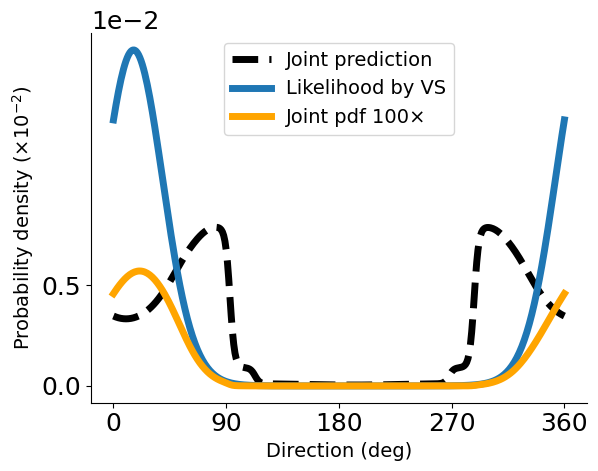

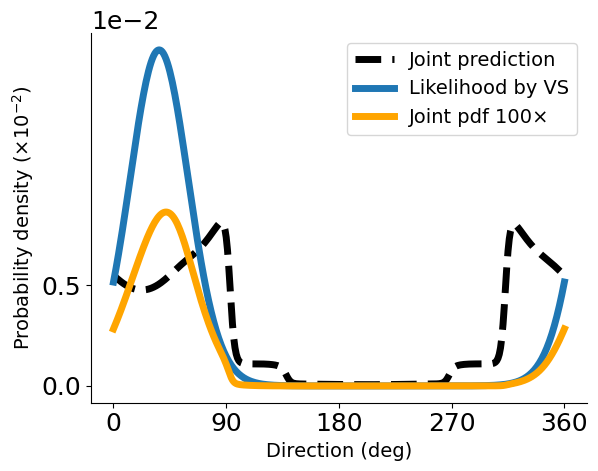

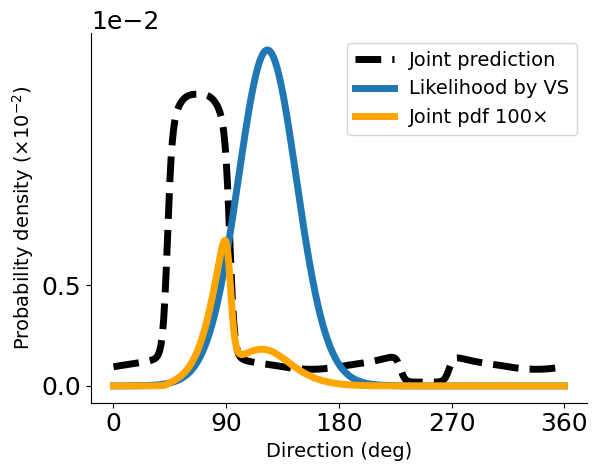

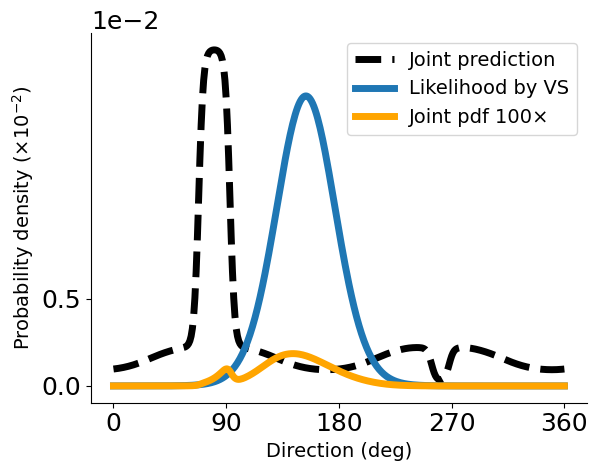

In [7]:
### secant**2 prediction
plt.rcParams.update({'font.size': 18})

for dirdiff in [20,45,135,160][:]:
    plt.figure()
    a=-90+(-3)
    b=90-(-3)
    c=0.01# c=np.array([.01,.05,.1])[np.newaxis, :]
    alpha=0.8
    threshold=2
    # dirdiff=45
    x=np.linspace(0,360,361)[:, np.newaxis] # have to be 1 deg step for easy normalization of the distribution.

    ### mollified uniform for c1 and c2
    _,fg1=prediction(a,b,c,alpha)
    # plt.plot(x,fg1.ravel(),ls='--',label='MU1',lw=5,color='indianred')
    _,fg2=prediction(a+dirdiff,b+dirdiff,c,alpha)
    # plt.plot(x,fg2.ravel(),ls='--',label='MU2',lw=5,color='royalblue')

    ### prediction 1
    prob1=1/np.cos(np.deg2rad(x))**2
    prob1=smooth_threshold(prob1, threshold,softness=1.5)
    # plt.plot(x,prob1)
    
    newpred1=prob1*fg1
    auc = np.sum(newpred1*(x[1]-x[0]))
    newpred1/=auc
    # plt.plot(x,newpred1,label='Prediction C1',color='indianred',lw=5,ls='--')

    ### prediction 2
    prob2=1/np.cos(np.deg2rad(x)-np.deg2rad(dirdiff))**2
    prob2=smooth_threshold(prob2, threshold,softness=1.5)
    # plt.plot(x,prob2)
    
    newpred2=prob2*fg2
    auc = np.sum(newpred2*(x[1]-x[0]))
    newpred2/=auc
    # plt.plot(x,newpred2,label='Prediction C2',color='royalblue',lw=5,ls='--')

    ### joint prediction
    newjointpred=newpred1*newpred2
    auc = np.sum(newjointpred*(x[1]-x[0]))
    newjointpred/=auc
    plt.plot(x,newjointpred,ls='--',color='k',label='Joint prediction',lw=5)
    
    ### likelihood
    vm = vonmises.pdf(np.deg2rad(x),loc=np.deg2rad(VS_dict[dirdiff]),kappa=6)
    plt.plot(x,
             vm*np.deg2rad(1), # b/c von mises is based on rad instead of deg, so the function was normalized based on rad
             lw=5,label='Likelihood by VS')
    
    ### final joint pdf
    pstr = newjointpred*vm*np.deg2rad(1)*100
    plt.plot(x,pstr,lw=5,label='Joint pdf 100×',color='orange')
    
    ### plotting setup
    ax=plt.gca();ax.spines[['top','right']].set_visible(False)
    plt.xticks(np.arange(0,361,90))
    plt.xlabel('Direction (deg)',fontsize=14)
    plt.yticks([0,0.005])
    # plt.yticks([0,0.02])
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,-2))
    # plt.ylim(-.003,.025)
    plt.ylabel('Probability density ($×10^{-2}$)',fontsize=14)
    # plt.title(str(dirdiff)+' deg')
    plt.legend(fontsize=14)
    plt.show()